## Wine Quality Classifier (Model Deplyoment and Packaging):
* [Read Model from MLFlow Server](#read-model-mlflow)
* [Model Loaded Properly - Prediction on 6 DataPoints](#loaded-model-performance)
* [Local MLFlow Model Server](#local-model-server)
* [Model Packaging using Docker](#model-packaging)
* [MLFlow Model Server on OpenShift](#remote-model-server)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import mlflow
from mlflow.tracking import MlflowClient

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

import requests

import warnings
warnings.filterwarnings('ignore')

<a id="read-model-mlflow"></a>
# Read Model from MLFlow Server

In [12]:
# Log into MLflow
client = MlflowClient()

# Use the MLFlow instance deployed on the openshift cluster
mlflow.set_tracking_uri(uri="http://mlflow-mlflow.apps.cluster-db46l.dynamic.redhatworkshops.io/")

In [13]:
# Load Model from mlflow in loaded_model
MODEL_NAME = "LogRegWineModel"
MODEL_VERSION= 7
MODEL_URI = f"models:/{MODEL_NAME}/{MODEL_VERSION}"
loaded_model = mlflow.pyfunc.load_model(MODEL_URI)

<a id="loaded-model-performance"></a>
# Model Loaded Properly - Prediction on some DataPoints

In [19]:
# Load testing data and assign the X_test and y_test
test_df = pd.read_csv('testing_data/test_dataset.csv')

# Test Model Performance on 6 data points from testing_data/test_dataset.csvt
test_df_5 = test_df.head(5)

# Prepare the test input by dropping the 'best quality' columns
test_df_5_input = test_df_5.drop(['best quality'], axis=1)

# Extract the actual Wine Quality for the first 6 examples from test_dataset
actual_class_test = test_df_5['best quality']

# Use the trained model to predict the class for the test input
predicted_class_test = pd.DataFrame(loaded_model.predict(test_df_5_input), columns=['Predicted Wine Quality'])

# Combine predicted and actual classes into a single DataFrame
model_output = pd.concat([predicted_class_test, actual_class_test.reset_index(drop=True)], axis=1)

# Rename columns for clarity
model_output.columns = ['Predicted Wine Quality', 'Actual Wine Quality']

print(model_output)

   Predicted Wine Quality  Actual Wine Quality
0                       0                    0
1                       0                    0
2                       1                    1
3                       1                    1
4                       1                    0


<a id="local-model-server"></a>
# Local MLFlow Model Server

### Run this commands in git bash to 
* add the MLFlow instance on the OpenShift as tracking server
* and start a model server locally

```
export MLFLOW_TRACKING_URI=http://mlflow-mlflow.apps.cluster-db46l.dynamic.redhatworkshops.io
```

```
mlflow models serve -m "models:/MODEL_NAME/MODEL_VERSION" --env-manager local --no-conda
i.e mlflow models serve -m "models:/LogRegWineModel/1" --env-manager local --no-conda
```

when it is running, we can send prediction requests to the endpoint: *"http://127.0.0.1:5000/invocations"*, as shown below.

In [21]:
# Prepare the inference input 
test_df_5_input.to_dict(orient ='split')

{'index': [0, 1, 2, 3, 4],
 'columns': ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol'],
 'data': [[7.2, 0.635, 0.07, 2.6, 0.077, 16.0, 86.0, 0.99748, 3.51, 0.54, 9.7],
  [7.9, 0.35, 0.21, 1.9, 0.073, 46.0, 102.0, 0.9964, 3.27, 0.58, 9.5],
  [6.0, 0.51, 0.0, 2.1, 0.064, 40.0, 54.0, 0.995, 3.54, 0.93, 10.7],
  [10.2, 0.29, 0.49, 2.6, 0.059, 5.0, 13.0, 0.9976, 3.05, 0.74, 10.5],
  [6.5, 0.58, 0.0, 2.2, 0.096, 3.0, 13.0, 0.99557, 3.62, 0.62, 11.5]]}

In [22]:
# Prepare the inference Requests
inference_request = {
    "dataframe_split": 
        test_df_5_input.to_dict(orient ='split')
}

In [8]:
# Send a prediction request to the locally depoloyed model

endpoint = "http://127.0.0.1:5000/invocations"
response = requests.post(endpoint, json=inference_request)

# Check if the response is successful
if response.status_code == 200:
    # Process the prediction response
    predictions = pd.DataFrame(response.json()['predictions'], columns=['Predicted Wine Quality'])

    # Combine predictions with actual classes
    actual_class_test = test_df_5['best quality'].reset_index(drop=True)
    model_output = pd.concat([predictions, actual_class_test], axis=1)

    # Rename columns for clarity
    model_output.columns = ['Predicted Wine Quality', 'Actual Wine Quality']

    # Display the final output
    print(model_output)
    
else:
    print(f"Request failed with status code: {response.status_code}")
    print(f"Response content: {response.text}")

   Predicted Wine Quality  Actual Wine Quality
0                       0                    0
1                       0                    0
2                       1                    1
3                       1                    1
4                       1                    0
5                       1                    1


Now, stop the mlflow model server with ***"crtl+c"***

<a id="model-packaging"></a>
# Model Packaging using Docker

**!!! Attention !!!** 

When **Dockerfile** is generated, this line should be added to be able to deploy the image onto OpenShift cluster since only **non-root Containers** are allowed to be deployed. 

Add this line:

__*"RUN chgrp -R 0 /opt && chmod -R g=u /opt"*__

after this line:

__*"RUN chmod o+rwX /opt/mlflow/"*__

In [15]:
# Generate Dockerfile and dependencies to package the model 
!mlflow models generate-dockerfile -m "{MODEL_URI}" --env-manager local -d "wine_clf_package_modelver_{MODEL_VERSION}" --enable-mlserver

2025/02/02 20:44:55 INFO mlflow.models.cli: Generating Dockerfile for model models:/LogRegWineModel/7

2025/02/02 20:44:57 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'

2025/02/02 20:44:58 INFO mlflow.models.cli: Generated Dockerfile in directory wine_clf_package_modelver_7


<a id="remote-model-server"></a>
# MLFlow Model Server on OpenShift

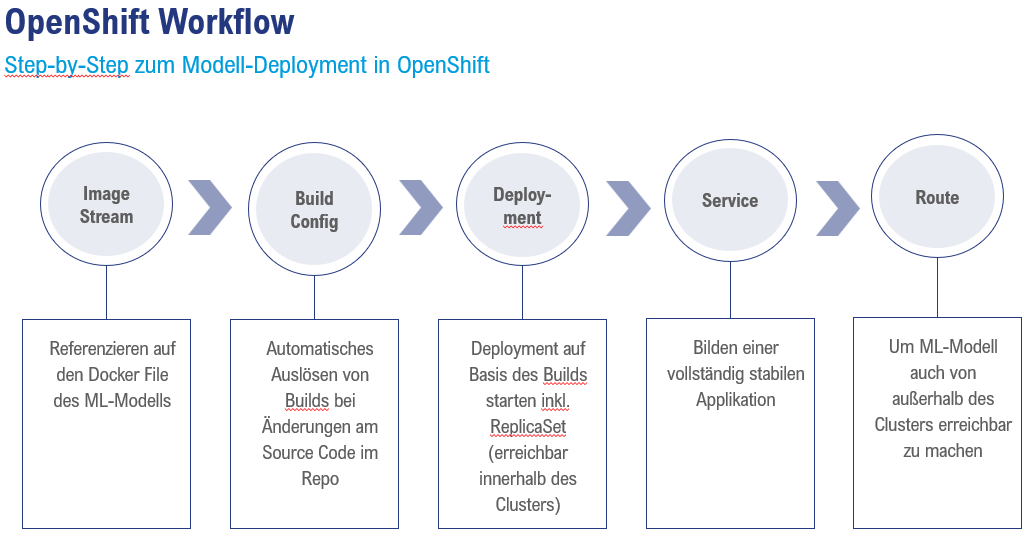

### It is time to build and deploy the model onto the OpenShift Clsuter

1. First push this new generated directory with Dockerfile and model artifacts to the preferred git (GitHub / GitLab / Azure DevOps / ...) repository. 
2. Then we go to OpenShift console to start a Build Process and pack the model in an Image
    * Info about the necessary resources on the openshift cluster will be disclosed during the workshop.
3. Deploy the Image onto the OpenShift cluster. 
4. We come back to this notebook to test the deployed model on the cluster.

In [23]:
# Send a prediction request to the depoloyed model on the OpenShift Cluster
BASE_URL = "http://model-clf-model-clf.apps.cluster-db46l.dynamic.redhatworkshops.io/"
endpoint = f"{BASE_URL}/invocations"
response = requests.post(endpoint, json=inference_request)

# Check if the response is successful
if response.status_code == 200:
    # Process the prediction response
    predictions = pd.DataFrame(response.json()['predictions'], columns=['Predicted Wine Quality'])

    # Combine predictions with actual classes
    actual_class_test = test_df_5['best quality'].reset_index(drop=True)
    model_output = pd.concat([predictions, actual_class_test], axis=1)

    # Rename columns for clarity
    model_output.columns = ['Predicted Wine Quality', 'Actual Wine Quality']

    # Display the final output
    print(model_output)
    
else:
    print(f"Request failed with status code: {response.status_code}")
    print(f"Response content: {response.text}")

   Predicted Wine Quality  Actual Wine Quality
0                       0                    0
1                       0                    0
2                       1                    1
3                       1                    1
4                       1                    0


<<<<< IGNORE BELOW CELLs >>>>>

<<<<< The notebook will be further developed >>>>>

In [ ]:
# !set MLFLOW_TRACKING_URL="http://mlflow-mlflow.apps.cluster-db46l.dynamic.redhatworkshops.io"
# !set MLFLOW_TRACKING_USERNAME=user
# !set MLFLOW_TRACKING_PASSWORD=user
# import os

# os.environ["MLFLOW_TRACKING_URI"] = "http://mlflow-mlflow.apps.cluster-db46l.dynamic.redhatworkshops.io"
# os.environ["MLFLOW_TRACKING_URI"] = "http://127.0.0.1:8000"
# os.env[]